# Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime
import sys
from bs4 import BeautifulSoup
import re
import unicodedata

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.metrics import confusion_matrix

%matplotlib inline

# Data Collection

## REST API

In [2]:
def getBoosterVersion(data):
    for x in data['rocket']:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

In [3]:
def getLaunchSite(data):
    for x in data['launchpad']:
        response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
        LaunchSite.append(response['name'])

In [4]:
def getPayloadData(data):
    for load in data['payloads']:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

In [5]:
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            if core["landpad"] is None:
                LandingPad.append("None")
            else:
                lp_response = requests.get("https://api.spacexdata.com/v4/landpads/"+core['landpad']).json()
                LandingPad.append(lp_response['type'] + ", " + lp_response['full_name'] + ", " + lp_response['locality'])

In [6]:
spacex_url="https://api.spacexdata.com/v4/launches/past"
response = requests.get(spacex_url)
response.status_code

200

In [7]:
df = pd.DataFrame(response.json())
df = df[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]
df = df[df['cores'].map(len)==1]
df = df[df['payloads'].map(len)==1]
df['cores'] = df['cores'].map(lambda x : x[0])
df['payloads'] = df['payloads'].map(lambda x : x[0])
df['date'] = pd.to_datetime(df['date_utc']).dt.date
df.head()

,rocket,payloads,launchpad,cores,flight_number,date_utc,date
0,5e9d0d95eda69955f709d1eb,5eb0e4b5b6c3bb0006eeb1e1,5e9e4502f5090995de566f86,"{'core': '5e9e289df35918033d3b2623', 'flight':...",1,2006-03-24T22:30:00.000Z,2006-03-24
1,5e9d0d95eda69955f709d1eb,5eb0e4b6b6c3bb0006eeb1e2,5e9e4502f5090995de566f86,"{'core': '5e9e289ef35918416a3b2624', 'flight':...",2,2007-03-21T01:10:00.000Z,2007-03-21
3,5e9d0d95eda69955f709d1eb,5eb0e4b7b6c3bb0006eeb1e5,5e9e4502f5090995de566f86,"{'core': '5e9e289ef3591855dc3b2626', 'flight':...",4,2008-09-28T23:15:00.000Z,2008-09-28
4,5e9d0d95eda69955f709d1eb,5eb0e4b7b6c3bb0006eeb1e6,5e9e4502f5090995de566f86,"{'core': '5e9e289ef359184f103b2627', 'flight':...",5,2009-07-13T03:35:00.000Z,2009-07-13
5,5e9d0d95eda69973a809d1ec,5eb0e4b7b6c3bb0006eeb1e7,5e9e4501f509094ba4566f84,"{'core': '5e9e289ef359185f2b3b2628', 'flight':...",6,2010-06-04T18:45:00.000Z,2010-06-04


In [8]:
df["date"].tail()

135    2021-11-11
136    2021-11-13
137    2021-11-24
138    2021-12-01
139    2021-12-09
Name: date, dtype: object

In [9]:
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []

In [10]:
getBoosterVersion(df)
getLaunchSite(df)
getPayloadData(df)
getCoreData(df)

In [11]:
launch_dict = {
    'FlightNumber': list(df['flight_number']),
    'Date': list(df['date']),
    'BoosterVersion':BoosterVersion,
    'PayloadMass':PayloadMass,
    'Orbit':Orbit,
    'LaunchSite':LaunchSite,
    'Outcome':Outcome,
    'Flights':Flights,
    'GridFins':GridFins,
    'Reused':Reused,
    'Legs':Legs,
    'LandingPad':LandingPad,
    'Block':Block,
    'ReusedCount':ReusedCount,
    'Serial':Serial
}

In [12]:
df_launch = pd.DataFrame(launch_dict)
df_launch['BoosterVersion'].unique()

array(['Falcon 1', 'Falcon 9'], dtype=object)

In [13]:
df_falcon9 = df_launch[df_launch['BoosterVersion']!='Falcon 1']

In [14]:
df_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003
5,8,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005
6,10,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007
7,11,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003
8,12,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004


In [15]:
df_falcon9.tail()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
122,136,2021-11-11,Falcon 9,12519.0,ISS,KSC LC 39A,True ASDS,2,True,True,True,"ASDS, A Shortfall of Gravitas, Port Canaveral",5.0,1,B1067
123,137,2021-11-13,Falcon 9,13260.0,LEO,CCSFS SLC 40,True ASDS,9,True,True,True,"ASDS, Just Read The Instructions, Port Canaveral",5.0,8,B1058
124,138,2021-11-24,Falcon 9,670.0,TLI,VAFB SLC 4E,True ASDS,2,True,True,True,"ASDS, Of Course I Still Love You, Port of Los ...",5.0,2,B1063
125,139,2021-12-01,Falcon 9,13260.0,PO,CCSFS SLC 40,True ASDS,9,True,True,True,"ASDS, A Shortfall of Gravitas, Port Canaveral",5.0,8,B1060
126,140,2021-12-09,Falcon 9,670.0,TLI,KSC LC 39A,True ASDS,5,True,True,True,"ASDS, Just Read The Instructions, Port Canaveral",5.0,4,B1061


## Web Scraping

In [16]:
def date_time(table_cells):
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    out=[i for i in table_cells.strings][0]
    return out

def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass

def extract_column_from_header(row):
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
    colunm_name = ' '.join(row.contents)
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name

In [17]:
wiki_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches"
response = requests.get(wiki_url)
response.status_code

200

In [18]:
soup = BeautifulSoup(response.text, "html5lib")

In [19]:
html_tables = []
for tbl in soup.find_all("table"):
    html_tables.append(tbl)
len(html_tables)

24

In [20]:
first_launch_table = html_tables[2]

In [21]:
column_names = []
for row in first_launch_table.find_all("th"):
    name = extract_column_from_header(row)
    if name is not None and len(name) > 0:
        column_names.append(name)
print(column_names)

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']


In [22]:
launch_dict= dict.fromkeys(column_names)
del launch_dict['Date and time ( )']

launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []

launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

In [23]:
extracted_row = 0
for table_number,table in enumerate(soup.find_all('table',"wikitable plainrowheaders collapsible")):
    for rows in table.find_all("tr"):
        if rows.th:
            if rows.th.string:
                flight_number=rows.th.string.strip()
                flag=flight_number.isdigit()
        else:
            flag=False
        row=rows.find_all('td') 
        if flag:
            extracted_row += 1
            launch_dict["Flight No."].append(flight_number)
            datatimelist=date_time(row[0])
            
            date = datatimelist[0].strip(',')
            launch_dict["Date"].append(date)

            time = datatimelist[1]
            launch_dict["Time"].append(time)

            bv=booster_version(row[1])
            if not(bv):
                bv=row[1].a.string
            launch_dict["Version Booster"].append(bv)

            launch_site = row[2].a.string
            launch_dict["Launch site"].append(launch_site)

            payload = row[3].a.string
            launch_dict["Payload"].append(payload)

            payload_mass = get_mass(row[4])
            launch_dict["Payload mass"].append(payload_mass)

            orbit = row[5].a.string
            launch_dict["Orbit"].append(orbit)

            if row[6].a:
                customer = row[6].a.string
            else:
                customer = row[6].string
            launch_dict["Customer"].append(customer)

            launch_outcome = list(row[7].strings)[0]
            launch_dict["Launch outcome"].append(launch_outcome)

            booster_landing = landing_status(row[8])
            launch_dict["Booster landing"].append(booster_landing)

In [24]:
df_ws=pd.DataFrame(launch_dict)
df_ws.head()

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
0,1,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success\n,F9 v1.0B0003,Failure,4 June 2010,18:45
1,2,CCAFS,Dragon,0,LEO,NASA,Success,F9 v1.0B0004,Failure,8 December 2010,15:43
2,3,CCAFS,Dragon,525 kg,LEO,NASA,Success,F9 v1.0B0005,No attempt\n,22 May 2012,07:44
3,4,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA,Success\n,F9 v1.0B0006,No attempt,8 October 2012,00:35
4,5,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA,Success\n,F9 v1.0B0007,No attempt\n,1 March 2013,15:10


In [25]:
df_ws.tail()

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
126,127,KSC,Crew-3,"~13,000 kg",LEO,NASA,Success\n,F9 B5B1067.2,Success,11 November 2021,02:03:31
127,128,CCSFS,Starlink,"~15,600 kg",LEO,SpaceX,Success\n,F9 B5B1058.9,Success,13 November 2021,12:19
128,129,VSFB,Double Asteroid Redirection Test (DART),624 kg,Heliocentric,NASA,Success\n,F9 B5B1063.3,Success,24 November 2021,06:21
129,130,CCSFS,Starlink,"~14,500 kg",LEO,SpaceX,Success\n,F9 B5B1060.9,Success,2 December 2021,23:12
130,131,KSC,Imaging X-ray Polarimetry Explorer,325 kg,LEO,NASA,Success\n,F9 B5,Success,9 December 2021,06:00


# Data Wrangling

## Exploration

### Mission dates

Objective: Merge two datasets.

In [26]:
df_ws["Date_V2"] = [datetime.datetime.strptime(dt, '%d %B %Y').date() for dt in df_ws["Date"]]
df_ws[["Date", "Date_V2"]]

,Date,Date_V2
0,4 June 2010,2010-06-04
1,8 December 2010,2010-12-08
2,22 May 2012,2012-05-22
3,8 October 2012,2012-10-08
4,1 March 2013,2013-03-01
...,...,...
126,11 November 2021,2021-11-11
127,13 November 2021,2021-11-13
128,24 November 2021,2021-11-24
129,2 December 2021,2021-12-02


In [27]:
set_api = set(df_falcon9["Date"])
set_ws = set(df_ws["Date_V2"])

In [28]:
# dates not being present in Web Scraping dataframe
list(set_api - set_ws)

[datetime.date(2016, 9, 1), datetime.date(2021, 12, 1)]

In [29]:
# dates not being present in API dataframe
list(set_ws - set_api)

[datetime.date(2010, 12, 8),
 datetime.date(2021, 12, 2),
 datetime.date(2012, 10, 8),
 datetime.date(2019, 2, 22),
 datetime.date(2018, 2, 22),
 datetime.date(2016, 6, 15),
 datetime.date(2020, 8, 7),
 datetime.date(2021, 5, 15),
 datetime.date(2018, 5, 22),
 datetime.date(2015, 3, 2)]

### No landing pads

Objective: Keep or discard flights without designated landing pads?

In [30]:
df_ws["Booster landing"].unique()

array(['Failure', 'No attempt\n', 'No attempt', 'Uncontrolled',
       'Controlled', 'Failure ', 'Precluded', 'Success'], dtype=object)

In [31]:
failureindex = list(df_ws[df_ws["Booster landing"] == "Failure "].index.values)
for index in failureindex:
    df_ws.at[index, "Booster landing"] = "Failure"

In [32]:
noattemptindex = list(df_ws[df_ws["Booster landing"] == "No attempt\n"].index.values)
for index in noattemptindex:
    df_ws.at[index, "Booster landing"] = "No attempt"

In [33]:
df_ws["Booster landing"].unique()

array(['Failure', 'No attempt', 'Uncontrolled', 'Controlled', 'Precluded',
       'Success'], dtype=object)

In [34]:
df_ws[df_ws["Booster landing"] == "No attempt"]

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time,Date_V2
2,3,CCAFS,Dragon,525 kg,LEO,NASA,Success,F9 v1.0B0005,No attempt,22 May 2012,07:44,2012-05-22
3,4,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA,Success\n,F9 v1.0B0006,No attempt,8 October 2012,00:35,2012-10-08
4,5,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA,Success\n,F9 v1.0B0007,No attempt,1 March 2013,15:10,2013-03-01
6,7,CCAFS,SES-8,"3,170 kg",GTO,SES,Success,F9 v1.1,No attempt,3 December 2013,22:41,2013-12-03
7,8,CCAFS,Thaicom 6,"3,325 kg",GTO,Thaicom,Success,F9 v1.1,No attempt,6 January 2014,22:06,2014-01-06
10,11,Cape Canaveral,AsiaSat 8,"4,535 kg",GTO,AsiaSat,Success,F9 v1.1,No attempt,5 August 2014,08:00,2014-08-05
11,12,Cape Canaveral,AsiaSat 6,"4,428 kg",GTO,AsiaSat,Success,F9 v1.1,No attempt,7 September 2014,05:00,2014-09-07
15,16,Cape Canaveral,ABS-3A,"4,159 kg",GTO,ABS,Success\n,F9 v1.1,No attempt,2 March 2015,03:50,2015-03-02
17,18,Cape Canaveral,TürkmenÄlem 52°E / MonacoSAT,"4,707 kg",GTO,None,Success\n,F9 v1.1,No attempt,27 April 2015,23:03,2015-04-27
30,31,KSC,EchoStar 23,"5,600 kg",GTO,EchoStar,Success\n,F9 FT,No attempt,16 March 2017,06:00,2017-03-16


In [35]:
set_ws_noattempt = set(df_ws[df_ws["Booster landing"] == "No attempt"]["Date_V2"])

In [36]:
# no landing attempts
df_falcon9[[True if df_falcon9.loc[i, "Date"] in set_ws_noattempt else False for i in list(df_falcon9.index.values)]]

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
5,8,2012-05-22,Falcon 9,525.00,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005
6,10,2013-03-01,Falcon 9,677.00,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007
8,12,2013-12-03,Falcon 9,3170.00,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004
9,13,2014-01-06,Falcon 9,3325.00,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1005
12,16,2014-08-05,Falcon 9,4535.00,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1008
13,17,2014-09-07,Falcon 9,4428.00,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1011
18,23,2015-04-27,Falcon 9,4707.00,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1016
31,37,2017-03-16,Falcon 9,5600.00,GTO,KSC LC 39A,None None,1,False,False,False,None,3.0,0,B1030
34,40,2017-05-15,Falcon 9,6070.00,GTO,KSC LC 39A,None None,1,False,False,False,None,3.0,0,B1034
38,44,2017-07-05,Falcon 9,6761.00,GTO,KSC LC 39A,None None,1,False,False,False,None,3.0,0,B1037


In [37]:
nolandingpadindex = list(df_falcon9[df_falcon9["LandingPad"] == "None"].index.values)
nonenoneoutcomeindex = list(df_falcon9[df_falcon9["Outcome"] == "None None"].index.values)
f9noattemptindex = list(df_falcon9[[True if df_falcon9.loc[i, "Date"] in set_ws_noattempt else False for i in list(df_falcon9.index.values)]].index.values)

In [38]:
len(nolandingpadindex), len(nonenoneoutcomeindex), len(f9noattemptindex)

(26, 19, 18)

In [39]:
# no landing pads despite attempted landing
df_falcon9.loc[list(set(nolandingpadindex) - set(f9noattemptindex))]

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003
7,11,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003
10,14,2014-04-18,Falcon 9,2296.0,ISS,CCSFS SLC 40,True Ocean,1,False,False,True,None,1.0,0,B1006
11,15,2014-07-14,Falcon 9,1316.0,LEO,CCSFS SLC 40,True Ocean,1,False,False,True,None,1.0,0,B1007
14,18,2014-09-21,Falcon 9,2216.0,ISS,CCSFS SLC 40,False Ocean,1,False,False,False,None,1.0,0,B1010
46,52,2017-12-23,Falcon 9,9600.0,PO,VAFB SLC 4E,True Ocean,2,True,True,False,None,3.0,1,B1036
16,20,2015-02-11,Falcon 9,570.0,ES-L1,CCSFS SLC 40,True Ocean,1,True,False,True,None,1.0,0,B1013
48,54,2018-01-31,Falcon 9,4230.0,GTO,CCSFS SLC 40,True Ocean,2,True,True,True,None,3.0,1,B1032


In [40]:
# none none outcome despite attempted landing
df_falcon9.loc[list(set(nonenoneoutcomeindex) - set(f9noattemptindex))]

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003


In [41]:
# no landing pads despite other than none none outcome
df_falcon9.loc[list(set(nolandingpadindex) - set(nonenoneoutcomeindex))]

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
7,11,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003
10,14,2014-04-18,Falcon 9,2296.0,ISS,CCSFS SLC 40,True Ocean,1,False,False,True,None,1.0,0,B1006
11,15,2014-07-14,Falcon 9,1316.0,LEO,CCSFS SLC 40,True Ocean,1,False,False,True,None,1.0,0,B1007
14,18,2014-09-21,Falcon 9,2216.0,ISS,CCSFS SLC 40,False Ocean,1,False,False,False,None,1.0,0,B1010
46,52,2017-12-23,Falcon 9,9600.0,PO,VAFB SLC 4E,True Ocean,2,True,True,False,None,3.0,1,B1036
16,20,2015-02-11,Falcon 9,570.0,ES-L1,CCSFS SLC 40,True Ocean,1,True,False,True,None,1.0,0,B1013
48,54,2018-01-31,Falcon 9,4230.0,GTO,CCSFS SLC 40,True Ocean,2,True,True,True,None,3.0,1,B1032


In [42]:
# Ocean outcomes
df_falcon9[[True if "Ocean" in df_falcon9["Outcome"][i].split(" ") else False for i in list(df_falcon9.index.values)]]

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
7,11,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003
10,14,2014-04-18,Falcon 9,2296.0,ISS,CCSFS SLC 40,True Ocean,1,False,False,True,None,1.0,0,B1006
11,15,2014-07-14,Falcon 9,1316.0,LEO,CCSFS SLC 40,True Ocean,1,False,False,True,None,1.0,0,B1007
14,18,2014-09-21,Falcon 9,2216.0,ISS,CCSFS SLC 40,False Ocean,1,False,False,False,None,1.0,0,B1010
16,20,2015-02-11,Falcon 9,570.0,ES-L1,CCSFS SLC 40,True Ocean,1,True,False,True,None,1.0,0,B1013
46,52,2017-12-23,Falcon 9,9600.0,PO,VAFB SLC 4E,True Ocean,2,True,True,False,None,3.0,1,B1036
48,54,2018-01-31,Falcon 9,4230.0,GTO,CCSFS SLC 40,True Ocean,2,True,True,True,None,3.0,1,B1032


As apparent, during most booster flights without a landing pad, no landing has been attempted - for various reasons.
One flight without landing pad - June 4, 2010 - has been a failure, as the booster has disintegrated upon reentry.
The remaining flights without landing pads have been directed to land in the ocean - with both successful and unsuccessful landing outcomes.

Therefore it makes sense not to drop the 'no landing pad' flights, as they also represent a fraction of realistic mission outcomes - whether they be mishaps or intentional no-reuse/end-of-life booster flights.

## Completing by hand

In [43]:
# dates not being present in Web Scraping dataframe
df_falcon9.loc[[df_falcon9[df_falcon9["Date"] == list(set_api - set_ws)[i]].index[0] for i in range(len(set_api - set_ws))]].sort_values("Date")

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
28,34,2016-09-01,Falcon 9,5500.0,GTO,CCSFS SLC 40,None ASDS,1,True,False,True,"ASDS, Of Course I Still Love You, Port of Los ...",3.0,0,B1028
125,139,2021-12-01,Falcon 9,13260.0,PO,CCSFS SLC 40,True ASDS,9,True,True,True,"ASDS, A Shortfall of Gravitas, Port Canaveral",5.0,8,B1060


In [44]:
dict_falcon9 = {"index": [28, 125],
                "delete": [True, False]}

In [45]:
# dates not being present in API dataframe
df_ws.loc[[df_ws[df_ws["Date_V2"] == list(set_ws - set_api)[i]].index[0] for i in range(len(set_ws - set_api))]].sort_values("Date_V2")

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time,Date_V2
1,2,CCAFS,Dragon,0,LEO,NASA,Success,F9 v1.0B0004,Failure,8 December 2010,15:43,2010-12-08
3,4,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA,Success\n,F9 v1.0B0006,No attempt,8 October 2012,00:35,2012-10-08
15,16,Cape Canaveral,ABS-3A,"4,159 kg",GTO,ABS,Success\n,F9 v1.1,No attempt,2 March 2015,03:50,2015-03-02
25,26,Cape Canaveral,ABS-2A,"3,600 kg",GTO,ABS,Success\n,F9 FT,Failure,15 June 2016,14:29,2016-06-15
48,49,VAFB,Paz,"2,150 kg",SSO,Hisdesat,Success,F9 FTB1038.2,No attempt,22 February 2018,14:17,2018-02-22
54,55,VAFB,Iridium NEXT,"6,460 kg",Polar,Iridium Communications,Success,F9 B4B1043.2,No attempt,22 May 2018,19:47,2018-05-22
67,68,CCAFS,Nusantara Satu,"4,850 kg",GTO,PSN,Success\n,F9 B5B1048.3,Success,22 February 2019,01:45,2019-02-22
89,90,KSC,Starlink,"14,932 kg",LEO,SpaceX,Success\n,F9 B5,Success,7 August 2020,05:12,2020-08-07
117,118,KSC,Starlink,"~14,000 kg",LEO,SpaceX,Success\n,F9 B5B1058.8,Success,15 May 2021,22:56,2021-05-15
129,130,CCSFS,Starlink,"~14,500 kg",LEO,SpaceX,Success\n,F9 B5B1060.9,Success,2 December 2021,23:12,2021-12-02


In [46]:
dict_ws = {"index": [1, 3, 15, 25, 48, 54, 67, 89, 117, 129],
           "delete": [False, True, True, False, True, True, False, False, False, True]}

In [47]:
df_ws_add = df_ws.loc[[dict_ws["index"][i] for i in list(range(len(dict_ws["index"]))) if dict_ws["delete"][i] == False]]
df_ws_add

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time,Date_V2
1,2,CCAFS,Dragon,0,LEO,NASA,Success,F9 v1.0B0004,Failure,8 December 2010,15:43,2010-12-08
25,26,Cape Canaveral,ABS-2A,"3,600 kg",GTO,ABS,Success\n,F9 FT,Failure,15 June 2016,14:29,2016-06-15
67,68,CCAFS,Nusantara Satu,"4,850 kg",GTO,PSN,Success\n,F9 B5B1048.3,Success,22 February 2019,01:45,2019-02-22
89,90,KSC,Starlink,"14,932 kg",LEO,SpaceX,Success\n,F9 B5,Success,7 August 2020,05:12,2020-08-07
117,118,KSC,Starlink,"~14,000 kg",LEO,SpaceX,Success\n,F9 B5B1058.8,Success,15 May 2021,22:56,2021-05-15


In [48]:
# Fill in missing information by hand - source: various internet sites
boosterversion_add = ["Falcon 9", "Falcon 9", "Falcon 9", "Falcon 9", "Falcon 9"]
payloadmass_add = [5500, 3600, 4850, 14932, 13700]
launchsite_add = ["CCSFS SLC 40", "CCSFS SLC 40", "CCSFS SLC 40", "KSC LC 39A", "KSC LC 39A"]
outcome_add = ["None Ocean", "False ASDS", "True ASDS", "True ASDS", "True ASDS"]
flights_add = [1, 1, 3, 5, 8]
gridfins_add = [False, True, True, True, True]
reused_add = [False, False, True, True, True]
legs_add = [False, True, True, True, True]
landingpad_add = ["None",
                  "ASDS, Of Course I Still Love You, Port of Los Angeles",
                  "ASDS, Of Course I Still Love You, Port of Los Angeles",
                  "ASDS, Of Course I Still Love You, Port of Los Angeles",
                  "ASDS, Of Course I Still Love You, Port of Los Angeles"]
block_add = [1, 2, 5, 5, 5]
reusedcount_add = [0, 0, 4, 9, 8]
serial_add = ["B0004", "B1024", "B1048", "B1051", "B1058"]

In [49]:
dict_falcon9_add = {
    "FlightNumber": df_ws_add["Flight No."].to_list(),
    "Date": df_ws_add["Date_V2"].to_list(),
    "BoosterVersion": boosterversion_add,
    "PayloadMass": payloadmass_add,
    "Orbit": df_ws_add["Orbit"].to_list(),
    "LaunchSite": launchsite_add,
    "Outcome": outcome_add,
    "Flights": flights_add,
    "GridFins": gridfins_add,
    "Reused": reused_add,
    "Legs": legs_add,
    "LandingPad": landingpad_add,
    "Block": block_add,
    "ReusedCount": reusedcount_add,
    "Serial": serial_add
}

In [50]:
df_falcon9_add = pd.DataFrame(dict_falcon9_add)
df_falcon9_add

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
0,2,2010-12-08,Falcon 9,5500,LEO,CCSFS SLC 40,None Ocean,1,False,False,False,None,1,0,B0004
1,26,2016-06-15,Falcon 9,3600,GTO,CCSFS SLC 40,False ASDS,1,True,False,True,"ASDS, Of Course I Still Love You, Port of Los ...",2,0,B1024
2,68,2019-02-22,Falcon 9,4850,GTO,CCSFS SLC 40,True ASDS,3,True,True,True,"ASDS, Of Course I Still Love You, Port of Los ...",5,4,B1048
3,90,2020-08-07,Falcon 9,14932,LEO,KSC LC 39A,True ASDS,5,True,True,True,"ASDS, Of Course I Still Love You, Port of Los ...",5,9,B1051
4,118,2021-05-15,Falcon 9,13700,LEO,KSC LC 39A,True ASDS,8,True,True,True,"ASDS, Of Course I Still Love You, Port of Los ...",5,8,B1058


In [51]:
df_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass       12
Orbit              1
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad         0
Block              0
ReusedCount        0
Serial             0
dtype: int64

In [52]:
none_orbit_index = df_falcon9[df_falcon9["Orbit"].notnull() == False].index.values[0]
df_falcon9[df_falcon9["Orbit"].notnull() == False]

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
99,112,2020-12-19,Falcon 9,NaN,None,KSC LC 39A,True RTLS,5,True,True,True,"RTLS, Landing Zone 1, Cape Canaveral",5.0,5,B1059


In [53]:
df_falcon9.at[none_orbit_index, "Orbit"] = "LEO"
df_falcon9[df_falcon9.index.values == none_orbit_index]

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
99,112,2020-12-19,Falcon 9,NaN,LEO,KSC LC 39A,True RTLS,5,True,True,True,"RTLS, Landing Zone 1, Cape Canaveral",5.0,5,B1059


In [54]:
df_falcon9[df_falcon9["PayloadMass"].notnull() == False]

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003
33,39,2017-05-01,Falcon 9,NaN,LEO,KSC LC 39A,True RTLS,1,True,False,True,"RTLS, Landing Zone 1, Cape Canaveral",3.0,1,B1032
47,53,2018-01-08,Falcon 9,NaN,LEO,CCSFS SLC 40,True RTLS,1,True,False,True,"RTLS, Landing Zone 1, Cape Canaveral",4.0,1,B1043
76,88,2020-01-19,Falcon 9,NaN,SO,KSC LC 39A,None None,4,False,True,False,None,5.0,3,B1046
86,98,2020-07-20,Falcon 9,NaN,GEO,CCSFS SLC 40,True ASDS,2,True,True,True,"ASDS, Just Read The Instructions, Port Canaveral",5.0,8,B1058
94,107,2020-11-16,Falcon 9,NaN,ISS,KSC LC 39A,True ASDS,1,True,False,True,"ASDS, Just Read The Instructions, Port Canaveral",5.0,4,B1061
99,112,2020-12-19,Falcon 9,NaN,LEO,KSC LC 39A,True RTLS,5,True,True,True,"RTLS, Landing Zone 1, Cape Canaveral",5.0,5,B1059
102,115,2021-01-24,Falcon 9,NaN,SSO,CCSFS SLC 40,True ASDS,5,True,True,True,"ASDS, Of Course I Still Love You, Port of Los ...",5.0,8,B1058
110,123,2021-04-23,Falcon 9,NaN,ISS,KSC LC 39A,True ASDS,2,True,True,True,"ASDS, Of Course I Still Love You, Port of Los ...",5.0,4,B1061
118,132,2021-06-30,Falcon 9,NaN,SSO,CCSFS SLC 40,True RTLS,8,True,True,True,"RTLS, Landing Zone 1, Cape Canaveral",5.0,8,B1060


In [55]:
payloadindex = list(df_falcon9[df_falcon9["PayloadMass"].notnull() == False].index.values)
payloadmass = [5500, 2800, 0, 12050, 5500, 12500, 0, 3570, 12500, 11000, 12500, 12519]

In [56]:
for i,index in enumerate(payloadindex):
    df_falcon9.at[index, "PayloadMass"] = payloadmass[i]
df_falcon9.loc[payloadindex]

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
4,6,2010-06-04,Falcon 9,5500.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003
33,39,2017-05-01,Falcon 9,2800.0,LEO,KSC LC 39A,True RTLS,1,True,False,True,"RTLS, Landing Zone 1, Cape Canaveral",3.0,1,B1032
47,53,2018-01-08,Falcon 9,0.0,LEO,CCSFS SLC 40,True RTLS,1,True,False,True,"RTLS, Landing Zone 1, Cape Canaveral",4.0,1,B1043
76,88,2020-01-19,Falcon 9,12050.0,SO,KSC LC 39A,None None,4,False,True,False,None,5.0,3,B1046
86,98,2020-07-20,Falcon 9,5500.0,GEO,CCSFS SLC 40,True ASDS,2,True,True,True,"ASDS, Just Read The Instructions, Port Canaveral",5.0,8,B1058
94,107,2020-11-16,Falcon 9,12500.0,ISS,KSC LC 39A,True ASDS,1,True,False,True,"ASDS, Just Read The Instructions, Port Canaveral",5.0,4,B1061
99,112,2020-12-19,Falcon 9,0.0,LEO,KSC LC 39A,True RTLS,5,True,True,True,"RTLS, Landing Zone 1, Cape Canaveral",5.0,5,B1059
102,115,2021-01-24,Falcon 9,3570.0,SSO,CCSFS SLC 40,True ASDS,5,True,True,True,"ASDS, Of Course I Still Love You, Port of Los ...",5.0,8,B1058
110,123,2021-04-23,Falcon 9,12500.0,ISS,KSC LC 39A,True ASDS,2,True,True,True,"ASDS, Of Course I Still Love You, Port of Los ...",5.0,4,B1061
118,132,2021-06-30,Falcon 9,11000.0,SSO,CCSFS SLC 40,True RTLS,8,True,True,True,"RTLS, Landing Zone 1, Cape Canaveral",5.0,8,B1060


In [57]:
zero_payloadmass_index = list(df_falcon9[df_falcon9["PayloadMass"] == 0].index.values)
pm_mean = df_falcon9["PayloadMass"].mean()
df_falcon9["PayloadMass"].replace(to_replace=0, value=pm_mean, inplace=True)
df_falcon9.loc[zero_payloadmass_index]

c:\program files\python\python38\lib\site-packages\pandas\core\series.py:4506: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
47,53,2018-01-08,Falcon 9,7306.020732,LEO,CCSFS SLC 40,True RTLS,1,True,False,True,"RTLS, Landing Zone 1, Cape Canaveral",4.0,1,B1043
99,112,2020-12-19,Falcon 9,7306.020732,LEO,KSC LC 39A,True RTLS,5,True,True,True,"RTLS, Landing Zone 1, Cape Canaveral",5.0,5,B1059


In [58]:
df_falcon9.isnull().sum()

FlightNumber      0
Date              0
BoosterVersion    0
PayloadMass       0
Orbit             0
LaunchSite        0
Outcome           0
Flights           0
GridFins          0
Reused            0
Legs              0
LandingPad        0
Block             0
ReusedCount       0
Serial            0
dtype: int64

In [59]:
df_falcon9["LaunchSite"].unique()

array(['CCSFS SLC 40', 'VAFB SLC 4E', 'KSC LC 39A'], dtype=object)

In [60]:
df_falcon9 = df_falcon9.append(df_falcon9_add, ignore_index=True)
df_falcon9.drop(index=df_falcon9[df_falcon9["Date"] == datetime.date(2016, 9, 1)].index.values[0], inplace=True)
df_falcon9.sort_values("Date", inplace=True)
df_falcon9.reset_index(inplace=True)
df_falcon9.drop(columns="index", inplace=True)
df_falcon9["FlightNumber"] = list(range(1, df_falcon9.shape[0]+1))
df_falcon9

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
0,1,2010-06-04,Falcon 9,5500.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003
1,2,2010-12-08,Falcon 9,5500.0,LEO,CCSFS SLC 40,None Ocean,1,False,False,False,None,1.0,0,B0004
2,3,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005
3,4,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007
4,5,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,123,2021-11-11,Falcon 9,12519.0,ISS,KSC LC 39A,True ASDS,2,True,True,True,"ASDS, A Shortfall of Gravitas, Port Canaveral",5.0,1,B1067
123,124,2021-11-13,Falcon 9,13260.0,LEO,CCSFS SLC 40,True ASDS,9,True,True,True,"ASDS, Just Read The Instructions, Port Canaveral",5.0,8,B1058
124,125,2021-11-24,Falcon 9,670.0,TLI,VAFB SLC 4E,True ASDS,2,True,True,True,"ASDS, Of Course I Still Love You, Port of Los ...",5.0,2,B1063
125,126,2021-12-01,Falcon 9,13260.0,PO,CCSFS SLC 40,True ASDS,9,True,True,True,"ASDS, A Shortfall of Gravitas, Port Canaveral",5.0,8,B1060


# Predictive Analysis

## Preparation

In [61]:
landing_outcomes = df_falcon9["Outcome"].value_counts()
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None Ocean
7 None ASDS
8 False RTLS


In [62]:
bad_outcomes = set(landing_outcomes.keys()[[1, 3, 5, 6, 7, 8]])
bad_outcomes

{'False ASDS',
 'False Ocean',
 'False RTLS',
 'None ASDS',
 'None None',
 'None Ocean'}

In [63]:
# good outcomes
set(landing_outcomes.keys()) - bad_outcomes

{'True ASDS', 'True Ocean', 'True RTLS'}

In [64]:
landing_class = [0 if landing in bad_outcomes else 1 for landing in list(df_falcon9["Outcome"])]
df_falcon9["Class"]=landing_class
df_falcon9[["Outcome", "Class"]].head(10)

,Outcome,Class
0,None None,0
1,None Ocean,0
2,None None,0
3,None None,0
4,False Ocean,0
5,None None,0
6,None None,0
7,True Ocean,1
8,True Ocean,1
9,None None,0


In [65]:
df_X = df_falcon9.drop(columns=["Date", "BoosterVersion", "Outcome", "Class"])
df_X = pd.get_dummies(data=df_X, columns=["Orbit", "LaunchSite", "LandingPad", "Serial", "GridFins", "Reused", "Legs"])
df_X.astype("float64")
df_X.dtypes

FlightNumber       int64
PayloadMass      float64
Flights            int64
Block            float64
ReusedCount        int64
                  ...   
GridFins_True      uint8
Reused_False       uint8
Reused_True        uint8
Legs_False         uint8
Legs_True          uint8
Length: 90, dtype: object

In [66]:
df_X.columns.to_list()

['FlightNumber',
 'PayloadMass',
 'Flights',
 'Block',
 'ReusedCount',
 'Orbit_ES-L1',
 'Orbit_GEO',
 'Orbit_GTO',
 'Orbit_HEO',
 'Orbit_ISS',
 'Orbit_LEO',
 'Orbit_MEO',
 'Orbit_PO',
 'Orbit_SO',
 'Orbit_SSO',
 'Orbit_TLI',
 'Orbit_VLEO',
 'LaunchSite_CCSFS SLC 40',
 'LaunchSite_KSC LC 39A',
 'LaunchSite_VAFB SLC 4E',
 'LandingPad_ASDS, A Shortfall of Gravitas, Port Canaveral',
 'LandingPad_ASDS, Just Read The Instructions V1, Port Canaveral',
 'LandingPad_ASDS, Just Read The Instructions, Port Canaveral',
 'LandingPad_ASDS, Of Course I Still Love You, Port of Los Angeles',
 'LandingPad_None',
 'LandingPad_RTLS, Landing Zone 1, Cape Canaveral',
 'LandingPad_RTLS, Landing Zone 4, Vandenberg Air Force Base',
 'Serial_B0003',
 'Serial_B0004',
 'Serial_B0005',
 'Serial_B0007',
 'Serial_B1003',
 'Serial_B1004',
 'Serial_B1005',
 'Serial_B1006',
 'Serial_B1007',
 'Serial_B1008',
 'Serial_B1010',
 'Serial_B1011',
 'Serial_B1012',
 'Serial_B1013',
 'Serial_B1015',
 'Serial_B1016',
 'Serial_B1

In [67]:
X = df_X.to_numpy()
y = df_falcon9["Class"].astype("int32").to_numpy()

In [68]:
X.dtype, y.dtype

(dtype('float64'), dtype('int32'))

In [69]:
X.shape, y.shape

((127, 90), (127,))

In [70]:
#df_X.to_csv("SpaceX_ML_Predict_X.csv", index=False)
#df_falcon9["Class"].astype("int32").to_csv("SpaceX_ML_Predict_y.csv", index=False)

## Prediction

In [71]:
np.random.seed(0)

In [72]:
def plot_confusion_matrix(y,y_predict):
    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap="Blues")
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['did not land', 'land'])
    ax.yaxis.set_ticklabels(['did not land', 'landed'])
    plt.show()

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((101, 90), (26, 90), (101,), (26,))

### All Features

#### Logistic Regression

Best cross-validation accuracy: 0.8800
Test set score: 0.8846
Best parameters: {'lr__C': 0.1, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}


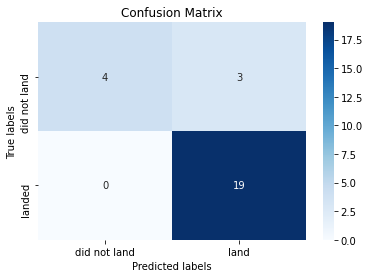

In [74]:
pipe_lr_all = Pipeline([("scaler", StandardScaler()), ("lr", LogisticRegression())])
param_lr_all ={"lr__C":[0.001, 0.01, 0.1, 1, 10, 100],'lr__penalty':['l2'], 'lr__solver':['lbfgs']}
grid_lr_all = GridSearchCV(pipe_lr_all, param_grid=param_lr_all, cv=10)
grid_lr_all.fit(X_train, y_train)

cv_score_lr_all = grid_lr_all.best_score_
score_lr_all = grid_lr_all.score(X_test, y_test)
print("Best cross-validation accuracy: {:.4f}".format(cv_score_lr_all))
print("Test set score: {:.4f}".format(score_lr_all))
print("Best parameters: {}".format(grid_lr_all.best_params_))

y_hat_lr_all = grid_lr_all.predict(X_test)
plot_confusion_matrix(y_test, y_hat_lr_all)

#### Support Vector Machine

Best cross-validation accuracy: 0.8900
Test set score: 0.8462
Best parameters: {'svm__C': 0.03162277660168379, 'svm__gamma': 0.001, 'svm__kernel': 'linear'}


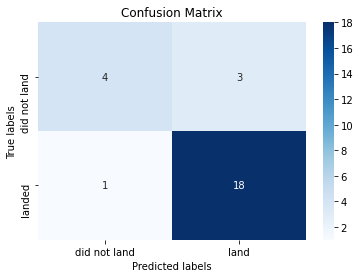

In [75]:
pipe_svm_all = Pipeline([("scaler", StandardScaler()), ("svm", SVC())])
param_svm_all = {'svm__kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'svm__C': np.logspace(-3, 3, 5),
              'svm__gamma':np.logspace(-3, 3, 5)}
grid_svm_all = GridSearchCV(pipe_svm_all, param_grid=param_svm_all, cv=10)
grid_svm_all.fit(X_train, y_train)

cv_score_svm_all = grid_svm_all.best_score_
score_svm_all = grid_svm_all.score(X_test, y_test)
print("Best cross-validation accuracy: {:.4f}".format(cv_score_svm_all))
print("Test set score: {:.4f}".format(score_svm_all))
print("Best parameters: {}".format(grid_svm_all.best_params_))

y_hat_svm_all = grid_svm_all.predict(X_test)
plot_confusion_matrix(y_test, y_hat_svm_all)

#### Decision Tree

Best cross-validation accuracy: 0.9209
Test set score: 0.9615
Best parameters: {'dt__criterion': 'gini', 'dt__max_depth': 4, 'dt__max_features': 'sqrt', 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 5, 'dt__splitter': 'best'}


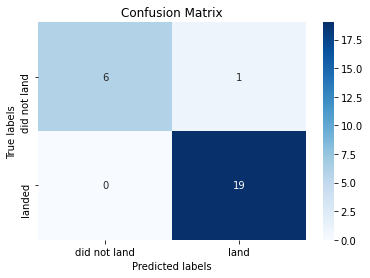

In [76]:
pipe_dt_all = Pipeline([("scaler", StandardScaler()), ("dt", DecisionTreeClassifier())])
param_dt_all = {'dt__criterion': ['gini', 'entropy'],
     'dt__splitter': ['best', 'random'],
     'dt__max_depth': [2*n for n in range(1,10)],
     'dt__max_features': ['auto', 'sqrt'],
     'dt__min_samples_leaf': [1, 2, 4],
     'dt__min_samples_split': [2, 5, 10]}
grid_dt_all = GridSearchCV(pipe_dt_all, param_grid=param_dt_all, cv=10)
grid_dt_all.fit(X_train, y_train)

cv_score_dt_all = grid_dt_all.best_score_
score_dt_all = grid_dt_all.score(X_test, y_test)
print("Best cross-validation accuracy: {:.4f}".format(cv_score_dt_all))
print("Test set score: {:.4f}".format(score_dt_all))
print("Best parameters: {}".format(grid_dt_all.best_params_))

y_hat_dt_all = grid_dt_all.predict(X_test)
plot_confusion_matrix(y_test, y_hat_dt_all)

#### K-Nearest Neighbors

Best cross-validation accuracy: 0.9009
Test set score: 0.8846
Best parameters: {'knn__algorithm': 'auto', 'knn__n_neighbors': 3, 'knn__p': 1}


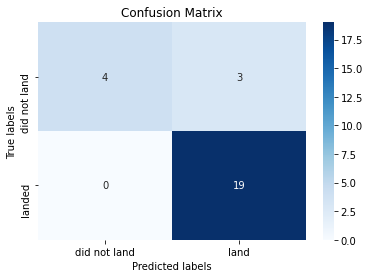

In [77]:
pipe_knn_all = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier())])
param_knn_all = {'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'knn__p': [1,2]}
grid_knn_all = GridSearchCV(pipe_knn_all, param_grid=param_knn_all, cv=10)
grid_knn_all.fit(X_train, y_train)

cv_score_knn_all = grid_knn_all.best_score_
score_knn_all = grid_knn_all.score(X_test, y_test)
print("Best cross-validation accuracy: {:.4f}".format(cv_score_knn_all))
print("Test set score: {:.4f}".format(score_knn_all))
print("Best parameters: {}".format(grid_knn_all.best_params_))

y_hat_knn_all = grid_knn_all.predict(X_test)
plot_confusion_matrix(y_test, y_hat_knn_all)

### Feature Selection

In [78]:
select_prelim = SelectKBest(score_func=f_classif, k=round(0.2*X_train.shape[1]))
select_prelim.fit(X_train, y_train)

c:\program files\python\python38\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [27 31 37 38 43 46 66] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\program files\python\python38\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


SelectKBest(k=18)

In [79]:
df_selected = pd.DataFrame({"feature": [], "F-score": [], "p-value": []})
df_selected["feature"] = df_X.columns.to_list()
df_selected["F-score"] = select_prelim.scores_
df_selected["p-value"] = select_prelim.pvalues_
df_selected = df_selected.sort_values("F-score", ascending=False)

<function matplotlib.pyplot.show(close=None, block=None)>

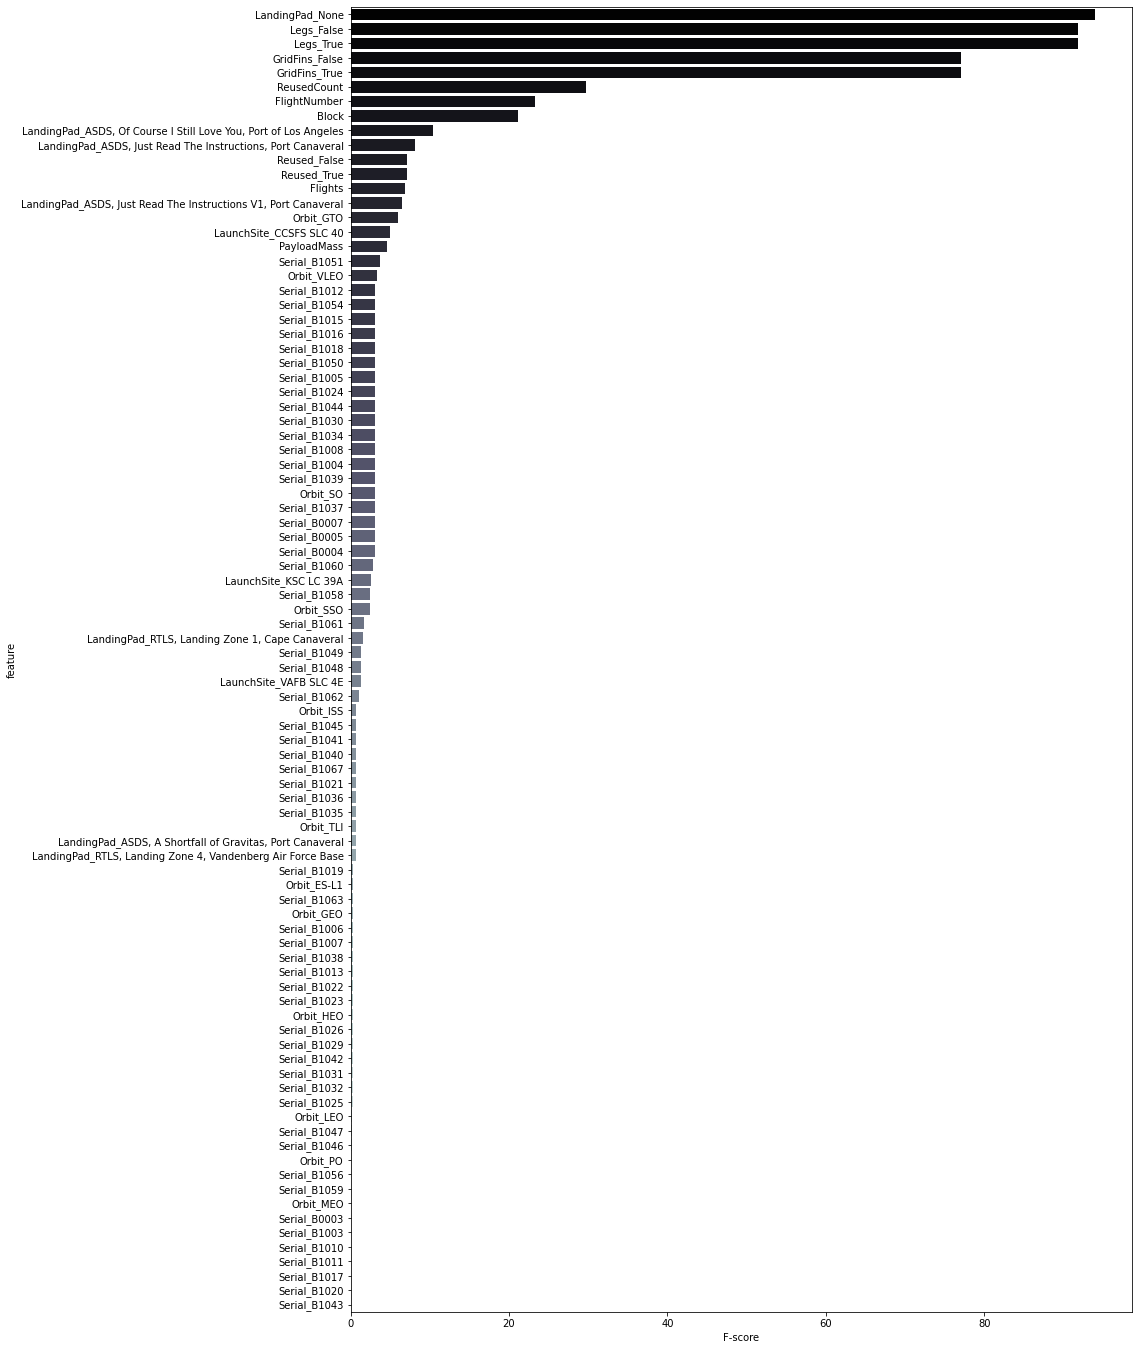

In [80]:
fig, ax = plt.subplots(figsize=(14,24))
sns.barplot(x="F-score", y="feature", data=df_selected, palette="bone", ax=ax)
plt.show

In [81]:
df_selected = df_selected[df_selected["p-value"] <= 0.05]
df_selected

,feature,F-score,p-value
24,LandingPad_None,93.942889,5.129849e-16
88,Legs_False,91.797114,8.974558e-16
89,Legs_True,91.797114,8.974558e-16
84,GridFins_False,77.124057,4.930600e-14
85,GridFins_True,77.124057,4.930600e-14
4,ReusedCount,29.710311,3.682462e-07
0,FlightNumber,23.349066,4.940210e-06
3,Block,21.151255,1.257124e-05
23,"LandingPad_ASDS, Of Course I Still Love You, P...",10.394153,1.712647e-03
22,"LandingPad_ASDS, Just Read The Instructions, P...",8.168317,5.197166e-03


In [82]:
select = SelectKBest(score_func=f_classif, k=df_selected.shape[0])
select.fit(X_train, y_train)

c:\program files\python\python38\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [27 31 37 38 43 46 66] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\program files\python\python38\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


SelectKBest(k=17)

In [83]:
X_train_selected = select.transform(X_train)
X_test_selected = select.transform(X_test)
print("Original number of features:\t{}".format(X_train.shape[1]))
print("Reduced number of features:\t{}".format(X_train_selected.shape[1]))

Original number of features:	90
Reduced number of features:	17


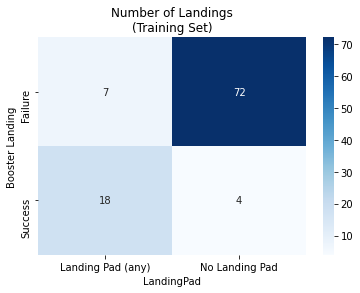

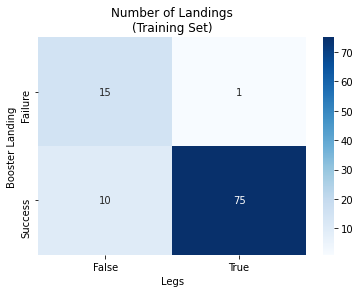

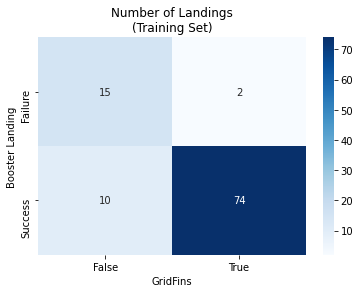

In [84]:
# First most useful feature - no landing pad
cm = confusion_matrix(X_train[:, df_selected.iloc[0,:].name], y_train)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues")
ax.set_xlabel(df_selected.iloc[0,:]["feature"][:df_selected.iloc[0,:]["feature"].find("_")])
ax.set_ylabel('Booster Landing')
ax.set_title('Number of Landings\n(Training Set)')
ax.xaxis.set_ticklabels(['Landing Pad (any)', 'No Landing Pad'])
ax.yaxis.set_ticklabels(['Failure', 'Success'])
plt.show()

# Second and third most useful features - Legs and Grid Fins
for i in range(2, 5, 2):
    cm = confusion_matrix(X_train[:, df_selected.iloc[i,:].name], y_train)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap="Blues")
    ax.set_xlabel(df_selected.iloc[i,:]["feature"][:df_selected.iloc[i,:]["feature"].find("_")])
    ax.set_ylabel('Booster Landing')
    ax.set_title('Number of Landings\n(Training Set)')
    ax.xaxis.set_ticklabels(['False', 'True'])
    ax.yaxis.set_ticklabels(['Failure', 'Success'])
    plt.show()

#### Logistic Regression

Best cross-validation accuracy: 0.9100
Test set score: 0.8077
Best parameters: {'lr__C': 10, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}


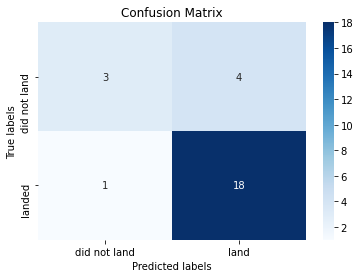

In [85]:
pipe_lr_selected = Pipeline([("scaler", StandardScaler()), ("lr", LogisticRegression())])
param_lr_selected ={"lr__C":[0.001, 0.01, 0.1, 1, 10, 100],'lr__penalty':['l2'], 'lr__solver':['lbfgs']}
grid_lr_selected = GridSearchCV(pipe_lr_selected, param_grid=param_lr_selected, cv=10)
grid_lr_selected.fit(X_train_selected, y_train)

cv_score_lr_selected = grid_lr_selected.best_score_
score_lr_selected = grid_lr_selected.score(X_test_selected, y_test)
print("Best cross-validation accuracy: {:.4f}".format(cv_score_lr_selected))
print("Test set score: {:.4f}".format(score_lr_selected))
print("Best parameters: {}".format(grid_lr_selected.best_params_))

y_hat_lr_selected = grid_lr_selected.predict(X_test_selected)
plot_confusion_matrix(y_test, y_hat_lr_selected)

#### Support Vector Machine

Best cross-validation accuracy: 0.9200
Test set score: 0.8846
Best parameters: {'svm__C': 1.0, 'svm__gamma': 0.03162277660168379, 'svm__kernel': 'poly'}


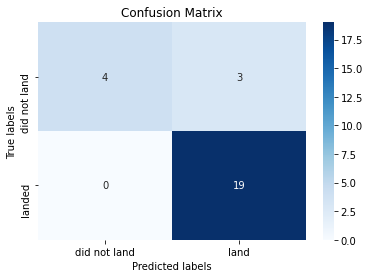

In [86]:
pipe_svm_selected = Pipeline([("scaler", StandardScaler()), ("svm", SVC())])
param_svm_selected = {'svm__kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'svm__C': np.logspace(-3, 3, 5),
              'svm__gamma':np.logspace(-3, 3, 5)}
grid_svm_selected = GridSearchCV(pipe_svm_selected, param_grid=param_svm_selected, cv=10)
grid_svm_selected.fit(X_train_selected, y_train)

cv_score_svm_selected = grid_svm_selected.best_score_
score_svm_selected = grid_svm_selected.score(X_test_selected, y_test)
print("Best cross-validation accuracy: {:.4f}".format(cv_score_svm_selected))
print("Test set score: {:.4f}".format(score_svm_selected))
print("Best parameters: {}".format(grid_svm_selected.best_params_))

y_hat_svm_selected = grid_svm_selected.predict(X_test_selected)
plot_confusion_matrix(y_test, y_hat_svm_selected)

#### Decision Tree

Best cross-validation accuracy: 0.9300
Test set score: 0.8462
Best parameters: {'dt__criterion': 'gini', 'dt__max_depth': 12, 'dt__max_features': 'auto', 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 10, 'dt__splitter': 'best'}


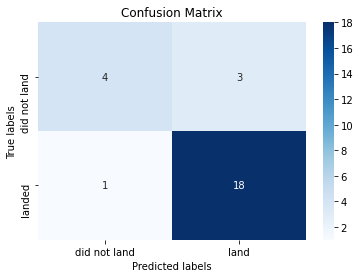

In [87]:
pipe_dt_selected = Pipeline([("scaler", StandardScaler()), ("dt", DecisionTreeClassifier())])
param_dt_selected = {'dt__criterion': ['gini', 'entropy'],
     'dt__splitter': ['best', 'random'],
     'dt__max_depth': [2*n for n in range(1,10)],
     'dt__max_features': ['auto', 'sqrt'],
     'dt__min_samples_leaf': [1, 2, 4],
     'dt__min_samples_split': [2, 5, 10]}
grid_dt_selected = GridSearchCV(pipe_dt_selected, param_grid=param_dt_selected, cv=10)
grid_dt_selected.fit(X_train_selected, y_train)

cv_score_dt_selected = grid_dt_selected.best_score_
score_dt_selected = grid_dt_selected.score(X_test_selected, y_test)
print("Best cross-validation accuracy: {:.4f}".format(cv_score_dt_selected))
print("Test set score: {:.4f}".format(score_dt_selected))
print("Best parameters: {}".format(grid_dt_selected.best_params_))

y_hat_dt_selected = grid_dt_selected.predict(X_test_selected)
plot_confusion_matrix(y_test, y_hat_dt_selected)

#### K-Nearest Neighbors

Best cross-validation accuracy: 0.9009
Test set score: 0.8077
Best parameters: {'knn__algorithm': 'auto', 'knn__n_neighbors': 1, 'knn__p': 2}


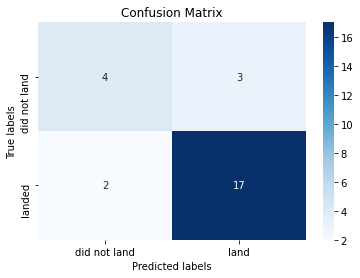

In [88]:
pipe_knn_selected = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier())])
param_knn_selected = {'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'knn__p': [1,2]}
grid_knn_selected = GridSearchCV(pipe_knn_selected, param_grid=param_knn_selected, cv=10)
grid_knn_selected.fit(X_train_selected, y_train)

cv_score_knn_selected = grid_knn_selected.best_score_
score_knn_selected = grid_knn_selected.score(X_test_selected, y_test)
print("Best cross-validation accuracy: {:.4f}".format(cv_score_knn_selected))
print("Test set score: {:.4f}".format(score_knn_selected))
print("Best parameters: {}".format(grid_knn_selected.best_params_))

y_hat_knn_selected = grid_knn_selected.predict(X_test_selected)
plot_confusion_matrix(y_test, y_hat_knn_selected)

## Summary

In [89]:
dict_score = {"Model": ["Logistic Regression", "Logistic Regression",
                       "Support Vector Machine", "Support Vector Machine",
                       "Decision Tree", "Decision Tree",
                       "K-Nearest Neighbors", "K-Nearest Neighbors"],
              "Features": ["All", "Selected",
                          "All", "Selected",
                          "All", "Selected",
                          "All", "Selected"],
              "Cross-Validation": [cv_score_lr_all, cv_score_lr_selected,
                                  cv_score_svm_all, cv_score_svm_selected,
                                  cv_score_dt_all, cv_score_dt_selected,
                                  cv_score_knn_all, cv_score_knn_selected],
             "Test": [score_lr_all, score_lr_selected,
                     score_svm_all, score_svm_selected,
                     score_dt_all, score_dt_selected,
                     score_knn_all, score_knn_selected]}
df_score = pd.DataFrame(dict_score)
df_score

,Model,Features,Cross-Validation,Test
0,Logistic Regression,All,0.880000,0.884615
1,Logistic Regression,Selected,0.910000,0.807692
2,Support Vector Machine,All,0.890000,0.846154
3,Support Vector Machine,Selected,0.920000,0.884615
4,Decision Tree,All,0.920909,0.961538
5,Decision Tree,Selected,0.930000,0.846154
6,K-Nearest Neighbors,All,0.900909,0.884615
7,K-Nearest Neighbors,Selected,0.900909,0.807692


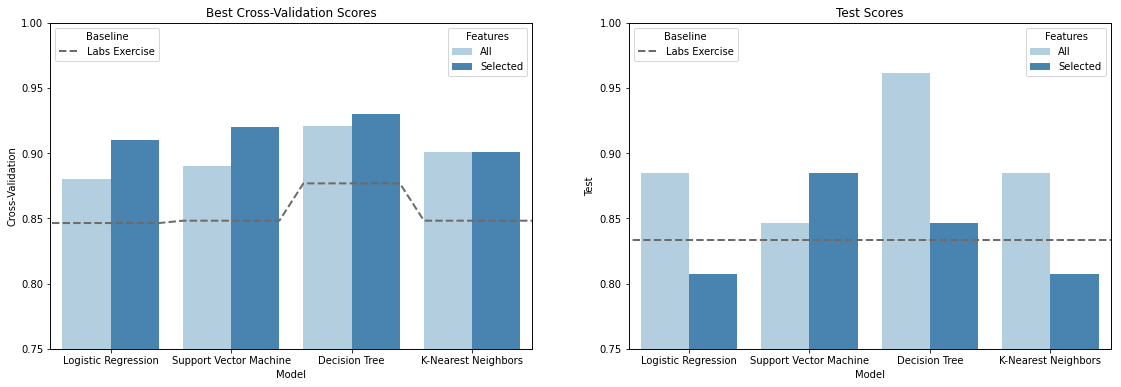

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19,6))

sns.barplot(x="Model", y="Cross-Validation", data=df_score, hue="Features", ax=ax1, palette="Blues")
ax1.set_title("Best Cross-Validation Scores")
ax1.set_ylim(bottom=0.75, top=1)
ax1.legend(loc="upper right", title="Features")

ax3 = ax1.twinx()
ax3.set_xlim(ax1.get_xlim())
ax3.set_ylim(bottom=0.75, top=1)
ax3.get_yaxis().set_visible(False)
ax3.plot([-1, 0.4, 0.6, 1.4, 1.6, 2.4, 2.6, 4],
         [0.8464, 0.8464, 0.8482, 0.8482, 0.8768, 0.8768, 0.8482, 0.8482],
         color="#6D6B6A", linestyle="dashed", linewidth=2, label="Labs Exercise")
ax3.legend(loc="upper left", title="Baseline")

sns.barplot(x="Model", y="Test", data=df_score, hue="Features", ax=ax2, palette="Blues")
ax2.set_title("Test Scores")
ax2.set_ylim(bottom=0.75, top=1)
ax2.legend(loc="upper right", title="Features")

ax4 = ax2.twinx()
ax4.set_xlim(ax2.get_xlim())
ax4.set_ylim(bottom=0.75, top=1)
ax4.get_yaxis().set_visible(False)
ax4.plot([-1,4], [0.8333, 0.8333], color="#6D6B6A", linestyle="dashed", linewidth=2, label="Labs Exercise")
ax4.legend(loc="upper left", title="Baseline")

plt.show()

Findings:
* Whilst performing feature selection - based on the training set - improved cross-validation to some extent, it did not improve test performance - with the exception of SVM.
* As expected however, more data - compared to the baseline dataset used in the Labs Exercise - indeed resulted in improved model performance.
* The Decision Tree yielded the highest test score, equaling 0.96. This can already be considered satisfactory.

In [91]:
print("Performance with all features:\n")
print("Logistic Regression score:\t{:.4f}".format(score_lr_all))
print("Support Vector Machine score:\t{:.4f}".format(score_svm_all))
print("Decision Tree score:\t\t{:.4f}".format(score_dt_all))
print("K-Nearest Neighbors score:\t{:.4f}".format(score_knn_all))
print("\n\nPerformance with selected features:\n")
print("Logistic Regression score:\t{:.4f}".format(score_lr_selected))
print("Support Vector Machine score:\t{:.4f}".format(score_svm_selected))
print("Decision Tree score:\t\t{:.4f}".format(score_dt_selected))
print("K-Nearest Neighbors score:\t{:.4f}".format(score_knn_selected))

Performance with all features:

Logistic Regression score:	0.8846
Support Vector Machine score:	0.8462
Decision Tree score:		0.9615
K-Nearest Neighbors score:	0.8846


Performance with selected features:

Logistic Regression score:	0.8077
Support Vector Machine score:	0.8846
Decision Tree score:		0.8462
K-Nearest Neighbors score:	0.8077


### Best Model

The decision tree with all input features is the model with the best performance. Details are as follows:

In [92]:
print("Model:\t\t\t\tDecision Tree")
print("Parameters:")
for i in range(len(grid_dt_all.best_params_.keys())):
    if len(list(grid_dt_all.best_params_.keys())[i]) < 15:
        print("\t" + list(grid_dt_all.best_params_.keys())[i] + ":\t\t" + str(list(grid_dt_all.best_params_.values())[i]))
    else:
        print("\t" + list(grid_dt_all.best_params_.keys())[i] + ":\t" + str(list(grid_dt_all.best_params_.values())[i]))

Model:				Decision Tree
Parameters:
	dt__criterion:		gini
	dt__max_depth:		4
	dt__max_features:	sqrt
	dt__min_samples_leaf:	2
	dt__min_samples_split:	5
	dt__splitter:		best
